<img src='../img/joint_school_banner_2.png' alt='Training school and workshop on fire' align='center' width='100%'></img>

<br>

<hr>

<br>

# CAMS Carbon Monoxide forecasts

### About

This notebook provides you a practical introduction to the CAMS global atmospheric composition forecasts on multiple pressure levels. We will use the data to analyse the transport of plumes of carbon monoxide from the Mediterranean wildfires in early August 2021. This notebook shows you how to create a vertical cross-section plot of carbon monoxide on different pressure levels to better assess the vertical distribution of carbon monoxide (CO) in the atmosphere.

### Basic Facts

This notebook introduces you to the <a href='https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview' target='_blank'>CAMS global atmospheric composition forecasts and analyses</a>. The data has the following specifications:

**CAMS global atmospheric composition forecasts** <br>
> **Spatial resolution**: `0.4° x 0.4°` <br>
> **Spatial coverage**: `Global` <br>
> **Temporal resolution**:  `Single level: 1-hourly, Multi level: 3-hourly ` <br>
> **Temporal coverage**: `2015 to present` <br>
> **Data format**: `GRIB` or `zipped NetCDF`


### How to access the data

**Copernicus Atmosphere Data Store (ADS)**
CAMS global atmospheric composition forecasts are available for download via the [Copernicus Atmosphere Data Store (ADS)](https://ads.atmosphere.copernicus.eu/). You will need to create an ADS account [here](https://ads.atmosphere.copernicus.eu/user/register).

Data from the ADS can be downloaded in two ways:
* `manually` via the [ADS web interface](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview)
* `programmatically` with a Python package called cdsapi ([more information](https://ads.atmosphere.copernicus.eu/api-how-to))

<hr>

### Load libraries

In [1]:
# CDS API
import cdsapi
import os

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import clear_output

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id='request_data_volcanic_eruption'></a> 1. [optional] Request data from the ADS programmatically with the CDS API

The first step is to programmatically download the carbon monoxide data from the Atmosphere Data Store. The retrieve request below requests the following data:
> **Date**: 1 to 31 August 2021 <br>
> **Variable**: Carbon monoxide<br>
> **Type**: Forecast <br>
> **Pressure level**: [1000, 950, 925, 900, 850, 800, 700, 600, 500, 400, 300, 250, 200] <br>
> **Spatial resolution**: 0.4 deg x 0.4 deg <br>
> **Temporal resolution**: hourly <br>
> **Format**: zipped netcdf <br>

The data is downloaded with the filename `202108_global_analysis_co.netcdf_zip`. As this request takes some time, we have already downloaded this data for you and you may use it directly.

**Note:** Replace the hashes with your ADS credentials. You can find them [here](https://ads.atmosphere.copernicus.eu/api-how-to), once you are logged in.

In [ ]:
URL = '###########################'
KEY = '############################'

<br>

The next step is then to request the data with the help of the CDS API. Below, we request analysis data from the `CAMS global atmospheric composition forecast` dataset. We request carbon monoxide on different pressure levels (`carbon monoxide`) for the month of August 2021 for a geographical subset over Europe.

Let us store the dataset under the name `202108_global_analysis_co.netcdf_zip`.

In [ ]:
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'variable': 'carbon_monoxide',
        'date': '2021-08-01/2021-08-31',
        'time': [
            '00:00', '12:00',
        ],
        'leadtime_hour': '0',
        'type': 'forecast',
        'area': [
            70, -25, 30,
            45,
        ],
        'format': 'netcdf_zip',
        'pressure_level': [
            '200', '250', '300',
            '400', '500', '600',
            '700', '800', '850',
            '900', '925', '950',
            '1000',
        ],
    },
    '../../../eodata/lps_fire/cams/202108_global_analysis_co.netcdf_zip')

<br>

## <a id='cams_unzip_co'></a>2. [optional] Unzip the downloaded data file

The CAMS global atmospheric composition forecasts can be retrieved from the Atmosphere Data Store in two data formats, `GRIB` and `Zipped netCDF`. We downloaded the data as `Zipped netCDF` and for this reason, before we can load any data, we have to unzip the files. You can use the functions from the `zipfile` Python package to extract the content of a zip file. First, you construct a `ZipFile()` object and second, you apply the function `extractall()` to extract the content of the zip file. This step is optional as we have already unzipped the file for you. This is why the code is commented out.

From the zip archive, a `NetCDF` files with the filename `data.nc` is extracted. This file contains the CO values on the chosen pressure levels. 

In [3]:
# import zipfile
# with zipfile.ZipFile('../../../eodata/lps_fire/cams/202108_global_analysis_co.netcdf_zip', 'r') as zip_ref:
#     zip_ref.extractall('../../../eodata/lps_fire/cams/')

<br>

## <a id='meridional_mean_co'></a>3. Compute meridional mean plot of carbon monoxide over the Mediterranean in August 2021

The next step is now to load the carbon monoxide on different pressure levels to create a meridional mean plot to visualise the changing concentrations of CO at different longitudes and at various pressure levels of the atmosphere. We will focus on the latitudes between 20 and 40 degrees and average over the latitudinal axis. This allows us to visualise a two dimensional plot of CO concentrations by longitude and altitude.


In a first step, we want to load the file named `data.nc`, which contains the carbon monoxide values on different pressure levels. You can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_dataset` to read a NetCDF file. The result is a `xarray.Dataset` with four dimensions: `latitude`, `level`, `longitude` and `time`.

In [5]:
ds_co = xr.open_dataset('../../../eodata/lps_fire/cams/data.nc')
ds_co

<xarray.Dataset>
Dimensions:    (longitude: 176, latitude: 101, level: 13, time: 62)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.6 -24.2 -23.8 ... 44.2 44.6 45.0
  * latitude   (latitude) float32 70.0 69.6 69.2 68.8 ... 31.2 30.8 30.4 30.0
  * level      (level) int32 200 250 300 400 500 600 ... 850 900 925 950 1000
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-31T12:00:00
Data variables:
    co         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-05-16 15:45:39 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

<br>

The next step is to extract the data variable `co`. You can extract a data variable as `xarray.DataArray` by specifying the name of the variable in square brackets. The loaded data array reveals additional attributes of the variable, such as `units` and `long_name`. 

In [6]:
da_co = ds_co['co']
da_co

<xarray.DataArray 'co' (time: 62, level: 13, latitude: 101, longitude: 176)>
[14327456 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.6 -24.2 -23.8 ... 44.2 44.6 45.0
  * latitude   (latitude) float32 70.0 69.6 69.2 68.8 ... 31.2 30.8 30.4 30.0
  * level      (level) int32 200 250 300 400 500 600 ... 850 900 925 950 1000
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-31T12:00:00
Attributes:
    units:          kg kg**-1
    long_name:      Carbon monoxide mass mixing ratio
    standard_name:  mass_fraction_of_carbon_monoxide_in_air

<br>

Above, you see that the carbon monoxide values on pressure levels are disseminated as mass mixing ratios in kg of gas / kg of air. Trace gas concentrations at a particular pressure level in the atmosphere are often given as a `volume mixing ratio`, or simply mixing ratio. This unit is defined as the ratio of the number density of the gas to the total number density of the atmosphere. 

In other words, the CO volume mixing ratio is the density of CO divided by the density of all constituents of the atmosphere in a unit volume (i.e. the number of molecules per unit volume).
Therefore, an CO mixing ratio of 10**-9 means that the number density of CO is 10**-9 times the total number density of air in a unit volume. Following the standard convention for the earth's troposphere and stratosphere, this mixing ratio equals 1 ppbv (parts per billion by volume).

To convert data from MMR to VMR you only need molar masses of dry air and molar mass of the atmospheric species. For CO the formula is: 
* `VMR = 28.9644 / 28.0101 * 1e9 * MMR`

Find <a href='https://confluence.ecmwf.int/pages/viewpage.action?pageId=153391710' target='_blank'>here</a> more information about converting mass mixing ratio (MMR) to volume mixing ratio (VMR).

Below, we apply the formula above and convert the CO values to volume mixing ratio. <br>
**Note:** You will see that the operation drops the data array's attributes. We will re-assign the attributes after some more pre-processing steps.

In [7]:
da_co_vmr = 28.9644 / 28.0101 * 1e9 * da_co
da_co_vmr

<xarray.DataArray 'co' (time: 62, level: 13, latitude: 101, longitude: 176)>
array([[[[ 49.535843,  50.18877 ,  50.841934, ...,  29.292458,
           31.904408,  34.516594],
         [ 50.748592,  51.588207,  52.334476, ...,  39.554047,
           41.886204,  44.964634],
         [ 50.655247,  51.588207,  52.334476, ...,  47.763268,
           48.416435,  50.282112],
         ...,
         [ 51.774654,  55.319565,  59.237843, ...,  88.996544,
           88.9032  ,  88.80986 ],
         [ 53.08075 ,  57.278587,  62.409615, ...,  93.7542  ,
           93.381065,  93.101036],
         [ 54.2935  ,  58.771366,  64.46175 , ...,  99.63127 ,
           99.25813 ,  98.69831 ]],

        [[ 93.381065,  94.31379 ,  95.24674 , ...,  82.559654,
           83.585724,  84.70513 ],
         [ 95.24674 ,  96.08636 ,  96.92597 , ...,  87.970245,
           88.996544,  90.11595 ],
         [ 94.96695 ,  95.71323 ,  96.27281 , ...,  92.35477 ,
           92.63456 ,  93.474174],
...
         [112.22501 , 111.478745, 111.01226 , ..., 150.56631 ,
          156.25668 , 161.48082 ],
         [106.90777 , 105.88147 , 105.69502 , ..., 159.42847 ,
          166.05203 , 174.16792 ],
         [ 97.11243 ,  94.127335,  90.58243 , ..., 166.61162 ,
          175.56735 , 186.10873 ]],

        [[140.02469 , 139.55821 , 138.81194 , ..., 128.83015 ,
          129.4833  , 130.0429  ],
         [137.97234 , 132.4684  , 132.28195 , ..., 123.60625 ,
          123.60625 , 123.97938 ],
         [142.35686 , 135.64017 , 131.72212 , ..., 123.046425,
          122.67329 , 122.300156],
         ...,
         [109.9862  , 109.61306 , 109.23993 , ..., 150.19318 ,
          156.16359 , 161.48082 ],
         [104.48227 , 103.36286 , 102.7097  , ..., 159.33536 ,
          165.9587  , 174.16792 ],
         [ 93.84731 ,  90.76888 ,  87.59711 , ..., 166.79831 ,
          175.7538  , 186.20207 ]]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.6 -24.2 -23.8 ... 44.2 44.6 45.0
  * latitude   (latitude) float32 70.0 69.6 69.2 68.8 ... 31.2 30.8 30.4 30.0
  * level      (level) int32 200 250 300 400 500 600 ... 850 900 925 950 1000
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-31T12:00:00

<br>

In a next step, we create the daily averages of carbon monoxide in the atmosphere over the Mediterranean. The xarray function `resample()` allows us to resample the time dimension from a 12-hourly resolution to a daily average. With the function `resample()` you define the resolution and with a subsequent aggregation function (e.g. mean), you define the aggregation level.

In [8]:
da_co_daily = da_co_vmr.resample(time='1D').mean()
da_co_daily

<xarray.DataArray 'co' (time: 31, level: 13, latitude: 101, longitude: 176)>
array([[[[ 54.106934,  54.57329 ,  54.94655 , ...,  28.965876,
           30.551762,  32.27766 ],
         [ 54.75998 ,  55.27301 ,  55.832714, ...,  35.122852,
           37.50168 ,  39.973854],
         [ 54.619965,  55.08644 ,  55.55292 , ...,  41.233154,
           43.0524  ,  45.38456 ],
         ...,
         [ 65.5346  ,  65.95441 ,  65.95452 , ...,  92.54145 ,
           92.12164 ,  91.841736],
         [ 66.84069 ,  68.14667 ,  69.172966, ...,  95.57333 ,
           95.386765,  95.38664 ],
         [ 67.63364 ,  69.45276 ,  71.2251  , ...,  99.771164,
           99.771164,  99.537926]],

        [[ 98.79166 ,  99.81784 , 101.077255, ...,  86.384476,
           87.22397 ,  88.11014 ],
         [103.36275 , 104.20236 , 105.08864 , ...,  89.0431  ,
           90.20929 ,  91.28203 ],
         [105.55501 , 106.25472 , 106.76776 , ...,  90.535645,
           91.468475,  92.634674],
...
         [ 95.153404,  95.013504,  94.920166, ..., 139.3251  ,
          143.5696  , 147.20786 ],
         [ 91.561935,  91.04879 ,  90.9089  , ..., 143.4297  ,
          147.1613  , 153.45818 ],
         [ 87.317314,  86.15123 ,  84.56535 , ..., 146.22833 ,
          151.126   , 158.72885 ]],

        [[138.76538 , 136.66635 , 134.66064 , ..., 128.22377 ,
          128.17722 , 127.99065 ],
         [136.0133  , 128.83026 , 126.2182  , ..., 127.52429 ,
          126.68468 , 126.171646],
         [138.5787  , 131.11575 , 127.15103 , ..., 128.87694 ,
          127.80408 , 126.68468 ],
         ...,
         [ 92.49478 ,  92.72802 ,  92.86792 , ..., 138.90529 ,
          142.59021 , 149.35344 ],
         [ 89.22966 ,  88.996544,  88.94975 , ..., 142.7301  ,
          146.41492 , 152.15208 ],
         [ 85.21828 ,  84.23877 ,  82.93279 , ..., 145.52875 ,
          151.03267 , 157.74936 ]]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2021-08-01 2021-08-02 ... 2021-08-31
  * longitude  (longitude) float32 -25.0 -24.6 -24.2 -23.8 ... 44.2 44.6 45.0
  * latitude   (latitude) float32 70.0 69.6 69.2 68.8 ... 31.2 30.8 30.4 30.0
  * level      (level) int32 200 250 300 400 500 600 ... 850 900 925 950 1000

<br>

### Compute meridional mean plot of carbon monoxide on different pressure levels 

The next step is now to prepare the data in order to create a meridional mean plot to visualise the changing concentrations of CO at different longitudes and at various pressure levels of the atmosphere. We will focus on the latitudinal zone between 20° and 40° and average over the latitudinal axis. This allows us to visualise a two dimensional plot of CO by longitude and altitude.

The first step is to filter the data array for all latitude entries between 25° and 60°. The xarray function `where()` allows us to filter any dimension of a data array. You can specify the keyword argument `drop`, which drops the values that were filtered out by the operation.

The size of the latitude dimension of the resulting data array has decreased from 101 to 76 grid points.

In [9]:
co_lat_area = da_co_daily.where((da_co_daily.latitude >= 25) & (da_co_daily.latitude <= 60), drop=True)
co_lat_area

<xarray.DataArray 'co' (time: 31, level: 13, latitude: 76, longitude: 176)>
array([[[[ 47.576702,  46.13083 ,  45.524456, ...,  50.46868 ,
           49.302605,  48.50966 ],
         [ 52.241135,  50.841812,  49.255928, ...,  58.21154 ,
           57.37193 ,  56.625656],
         [ 57.325375,  56.11251 ,  54.713303, ...,  61.05685 ,
           60.96351 ,  60.916836],
         ...,
         [ 65.5346  ,  65.95441 ,  65.95452 , ...,  92.54145 ,
           92.12164 ,  91.841736],
         [ 66.84069 ,  68.14667 ,  69.172966, ...,  95.57333 ,
           95.386765,  95.38664 ],
         [ 67.63364 ,  69.45276 ,  71.2251  , ...,  99.771164,
           99.771164,  99.537926]],

        [[ 94.78038 ,  94.7336  ,  94.50047 , ...,  93.98732 ,
           92.68135 ,  91.4686  ],
         [ 96.69261 ,  96.646065,  96.50605 , ...,  97.019196,
           95.99302 ,  94.78038 ],
         [ 99.91118 ,  99.398026,  98.79166 , ...,  97.53235 ,
           96.73929 ,  95.99302 ],
...
         [ 95.153404,  95.013504,  94.920166, ..., 139.3251  ,
          143.5696  , 147.20786 ],
         [ 91.561935,  91.04879 ,  90.9089  , ..., 143.4297  ,
          147.1613  , 153.45818 ],
         [ 87.317314,  86.15123 ,  84.56535 , ..., 146.22833 ,
          151.126   , 158.72885 ]],

        [[113.95091 , 113.95091 , 113.577774, ..., 135.9202  ,
          135.78018 , 135.64029 ],
         [114.18404 , 114.04414 , 113.8109  , ..., 138.81195 ,
          138.81207 , 138.81206 ],
         [114.41728 , 114.55729 , 114.79053 , ..., 141.47067 ,
          141.70392 , 141.93716 ],
         ...,
         [ 92.49478 ,  92.72802 ,  92.86792 , ..., 138.90529 ,
          142.59021 , 149.35344 ],
         [ 89.22966 ,  88.996544,  88.94975 , ..., 142.7301  ,
          146.41492 , 152.15208 ],
         [ 85.21828 ,  84.23877 ,  82.93279 , ..., 145.52875 ,
          151.03267 , 157.74936 ]]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2021-08-01 2021-08-02 ... 2021-08-31
  * longitude  (longitude) float32 -25.0 -24.6 -24.2 -23.8 ... 44.2 44.6 45.0
  * latitude   (latitude) float32 60.0 59.6 59.2 58.8 ... 31.2 30.8 30.4 30.0
  * level      (level) int32 200 250 300 400 500 600 ... 850 900 925 950 1000

In a last step before we are able to visualise the meridional mean plot of carbon monoxide, we have to compute the average over the latitudinal axis. You can use the xarray function `mean()` to create the average over the `latitude` dimension. The result is then a data array with three dimensions: `time`, `level` and `longitude`.

In [10]:
co_lat_area_mean = co_lat_area.mean(dim="latitude")
co_lat_area_mean

<xarray.DataArray 'co' (time: 31, level: 13, longitude: 176)>
array([[[ 78.73544 ,  79.378044,  80.01016 , ...,  68.48302 ,
          68.559135,  68.54563 ],
        [ 96.72644 ,  97.53534 ,  98.83526 , ...,  82.30858 ,
          82.43812 ,  82.66518 ],
        [101.98734 , 102.960144, 104.086945, ...,  91.39741 ,
          92.30508 ,  93.00967 ],
        ...,
        [ 97.92507 ,  96.618416,  95.141174, ..., 125.14479 ,
         126.21881 , 126.98599 ],
        [ 93.58779 ,  91.65269 ,  89.86243 , ..., 128.19136 ,
         128.23064 , 128.22633 ],
        [ 92.59231 ,  90.954895,  88.9259  , ..., 136.69218 ,
         136.50255 , 136.7278  ]],

       [[ 77.22935 ,  77.264946,  77.24099 , ...,  71.34301 ,
          71.10427 ,  70.79559 ],
        [ 94.17515 ,  94.46849 ,  94.85822 , ...,  81.57395 ,
          81.54879 ,  81.78386 ],
        [ 99.28264 ,  99.60179 , 100.80654 , ...,  88.66257 ,
          89.61512 ,  90.76157 ],
...
        [103.08472 , 104.27105 , 105.3396  , ..., 146.77832 ,
         147.59454 , 151.71027 ],
        [102.190506, 103.28788 , 104.4024  , ..., 150.69147 ,
         149.61803 , 152.23189 ],
        [102.71341 , 103.36338 , 103.86969 , ..., 155.50926 ,
         153.40479 , 157.03748 ]],

       [[ 76.89853 ,  76.842674,  76.82244 , ...,  73.875275,
          73.48618 ,  73.020355],
        [ 91.86504 ,  92.18357 ,  92.37384 , ...,  83.30531 ,
          83.082504,  82.837006],
        [ 91.61401 ,  92.94583 ,  93.94562 , ...,  88.012634,
          88.39254 ,  88.79881 ],
        ...,
        [119.3008  , 118.56126 , 117.726585, ..., 142.75462 ,
         144.94324 , 150.45824 ],
        [117.71248 , 116.85571 , 115.99647 , ..., 144.72597 ,
         145.74475 , 150.5951  ],
        [115.93814 , 115.48152 , 114.86417 , ..., 147.74126 ,
         148.58879 , 153.12064 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2021-08-01 2021-08-02 ... 2021-08-31
  * longitude  (longitude) float32 -25.0 -24.6 -24.2 -23.8 ... 44.2 44.6 45.0
  * level      (level) int32 200 250 300 400 500 600 ... 850 900 925 950 1000

Let us now also add the attributes again to the data array, as we might want to use the `units` and `long_name` for title and label information in the resulting plot. Since we made various changes to the data array, we first can assign the attributes from the initial data array `da_co`, but then modify and update specific attribute keys. The attributes we want to update are:
* `units`: `ppbv`
* `long_name`: `carbon monoxide volume mixing ratio`


In [11]:
co_lat_area_mean = co_lat_area_mean.assign_attrs(da_co.attrs)
co_lat_area_mean.attrs['long_name'] = 'carbon monoxide volume mixing ratio'
co_lat_area_mean.attrs['units'] = 'ppbv'

co_lat_area_mean.attrs

{'units': 'ppbv',
 'long_name': 'carbon monoxide volume mixing ratio',
 'standard_name': 'mass_fraction_of_carbon_monoxide_in_air'}

<br>

### Visualise the daily meridional mean of carbon monoxide as cross-section plot

Now we can visualise the vertical carbon monoxide distribution over the Mediterranean in August 2021. The pressure levels are on a non-linear scale. To ensure equal spacing between the values, let us create a regular scale.

In [12]:
y = np.arange(co_lat_area_mean.level.shape[0])+1
y = y[::-1]

<br>

The visualisation code can be divided in five main parts:
* **Initiate a matplotlib figure**: Initiatie a matplotlib figure object with `plt.figure()` and `plt.subplot()`
* **Plotting the data**: Plot the array with matplotlib's function `pcontourf` with longitude on the x-axis and pressure levels on the y-axis
* **Set y-axis tickmarks and labels**: Set regular-scaled y-axis ticks and labels
* **Set axes labels and title**
* **Specify a colorbar**: Specify a colorbar to be placed on the right and use the units attribute to add to the colorbar as unit

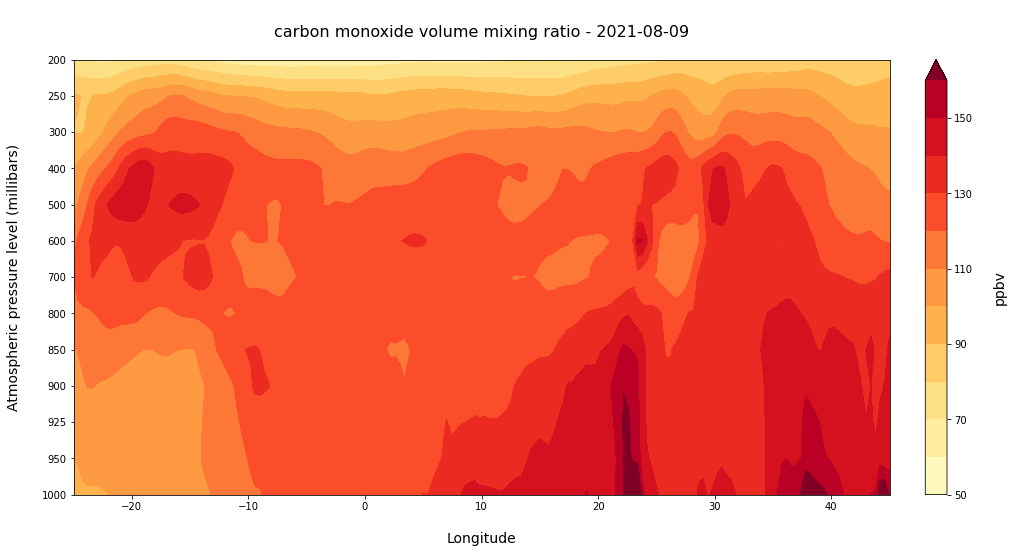

In [15]:
time_index = 8
# Define the figure and specify size
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot()

# Plot the figure with contourf
vdiv = 10
vmin = 50
vmax = 160+vdiv
clevs = np.arange(vmin,vmax,vdiv)
im = plt.contourf(co_lat_area_mean.longitude, y, co_lat_area_mean[time_index,:,:], clevs, cmap='YlOrRd', vmin=vmin, vmax=vmax, extend='max')

# Set x and y axis tickmarks, labels
ax.yaxis.set_ticks(y)
ax.yaxis.set_ticklabels(co_lat_area_mean.level.values)

# Set axes labels and title
ax.set_xlabel('\nLongitude', fontsize=14)
ax.set_ylabel('Atmospheric pressure level (millibars)\n', fontsize=14)
ax.set_title('\n'+ co_lat_area_mean.long_name + ' - ' + str(co_lat_area_mean.time[time_index].values)[0:10] + '\n', fontsize=16)

# Specify a colorbar
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('\n'+ co_lat_area_mean.units, fontsize=14)

The plot above shows you how the concentration and longitudinal distribution of carbon monoxide over the the Mediterranean varies at different pressure levels and at different longitudes. You see that most of the CO concentrations from the Mediterranean wildfires in early August 2021 were transported at atmospheric pressure levels between 800 to 1000 millibars.

## <a id='zonal_mean_co'></a>4. Compute zonal mean plot of carbon monoxide over the Mediterranean in August 2021

Next, we will compute a zonal mean plot to view the background values across the region. Before we are able to visualise the zonal mean plot of carbon monoxide, we have to compute the average over the longitudinal axis. You can use the xarray function `mean()` to create the average over the `longitude` dimension. The result is then a data array with three dimensions: `time`, `level` and `latitude`.

In [16]:
co_zonal_area_mean = co_lat_area.mean(dim="longitude")
co_zonal_area_mean

<xarray.DataArray 'co' (time: 31, level: 13, latitude: 76)>
array([[[ 57.24396 ,  58.27013 ,  59.342407, ...,  79.53227 ,
          80.75455 ,  81.94848 ],
        [ 97.037224,  96.68367 ,  96.695335, ...,  80.89528 ,
          81.891235,  82.75494 ],
        [119.05042 , 119.10078 , 119.25847 , ...,  80.7686  ,
          80.43548 ,  80.877266],
        ...,
        [ 97.54208 ,  97.125984,  97.07404 , ..., 114.45814 ,
         115.10425 , 115.432884],
        [ 96.64816 ,  96.14594 ,  96.278984, ..., 114.63199 ,
         114.77483 , 113.78602 ],
        [ 96.74145 ,  96.05823 ,  96.52864 , ..., 118.428154,
         117.31401 , 115.55134 ]],

       [[ 66.44367 ,  66.83881 ,  67.07122 , ...,  84.50965 ,
          85.29517 ,  86.13742 ],
        [106.823395, 105.68672 , 104.608345, ...,  88.199814,
          87.7233  ,  87.37161 ],
        [123.549164, 123.22875 , 122.68812 , ...,  87.34776 ,
          87.13282 ,  87.00986 ],
...
        [122.63987 , 123.25579 , 124.173294, ..., 111.83495 ,
         111.160736, 111.23706 ],
        [121.261765, 122.028206, 123.41931 , ..., 111.79785 ,
         111.19334 , 111.33405 ],
        [120.094086, 120.909294, 124.64902 , ..., 114.33623 ,
         113.13858 , 112.36712 ]],

       [[ 88.1574  ,  87.76226 ,  87.65916 , ...,  80.269035,
          80.70633 ,  81.1195  ],
        [107.46502 , 108.0894  , 109.23721 , ...,  82.94522 ,
          83.69524 ,  84.11529 ],
        [113.47253 , 113.20934 , 113.10175 , ...,  79.26592 ,
          79.63828 ,  79.72416 ],
        ...,
        [120.121635, 119.830925, 120.5531  , ..., 110.96569 ,
         110.97098 , 111.42893 ],
        [118.53655 , 118.62666 , 120.20459 , ..., 111.73079 ,
         111.53283 , 111.7565  ],
        [118.18831 , 118.753075, 121.872116, ..., 115.22112 ,
         114.293015, 112.997604]]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2021-08-01 2021-08-02 ... 2021-08-31
  * latitude  (latitude) float32 60.0 59.6 59.2 58.8 ... 31.2 30.8 30.4 30.0
  * level     (level) int32 200 250 300 400 500 600 700 800 850 900 925 950 1000

Let us now also add the attributes again to the data array, as we might want to use the `units` and `long_name` for title and label information in the resulting plot. Since we made various changes to the data array, we first can assign the attributes from the initial data array `da_co`, but then modify and update specific attribute keys. The attributes we want to update are:
* `units`: `ppbv`
* `long_name`: `carbon monoxide volume mixing ratio`


In [17]:
co_zonal_area_mean = co_zonal_area_mean.assign_attrs(da_co.attrs)
co_zonal_area_mean.attrs['long_name'] = 'carbon monoxide volume mixing ratio'
co_zonal_area_mean.attrs['units'] = 'ppbv'

co_zonal_area_mean.attrs

{'units': 'ppbv',
 'long_name': 'carbon monoxide volume mixing ratio',
 'standard_name': 'mass_fraction_of_carbon_monoxide_in_air'}

<br>

### Visualise the daily zonal mean of carbon monoxide as cross-section plot

Now we can visualise the vertical carbon monoxide distribution over the Mediterranean in August 2021. The pressure levels are on a non-linear scale. To ensure equal spacing between the values, let us create a regular scale.

In [18]:
y = np.arange(co_zonal_area_mean.level.shape[0])+1
y = y[::-1]

<br>

The visualisation code can be divided in five main parts:
* **Initiate a matplotlib figure**: Initiatie a matplotlib figure object with `plt.figure()` and `plt.subplot()`
* **Plotting the data**: Plot the array with matplotlib's function `pcontourf` with latitude on the x-axis and pressure levels on the y-axis
* **Set y-axis tickmarks and labels**: Set regular-scaled y-axis ticks and labels
* **Set axes labels and title**
* **Specify a colorbar**: Specify a colorbar to be placed on the right and use the units attribute to add to the colorbar as unit

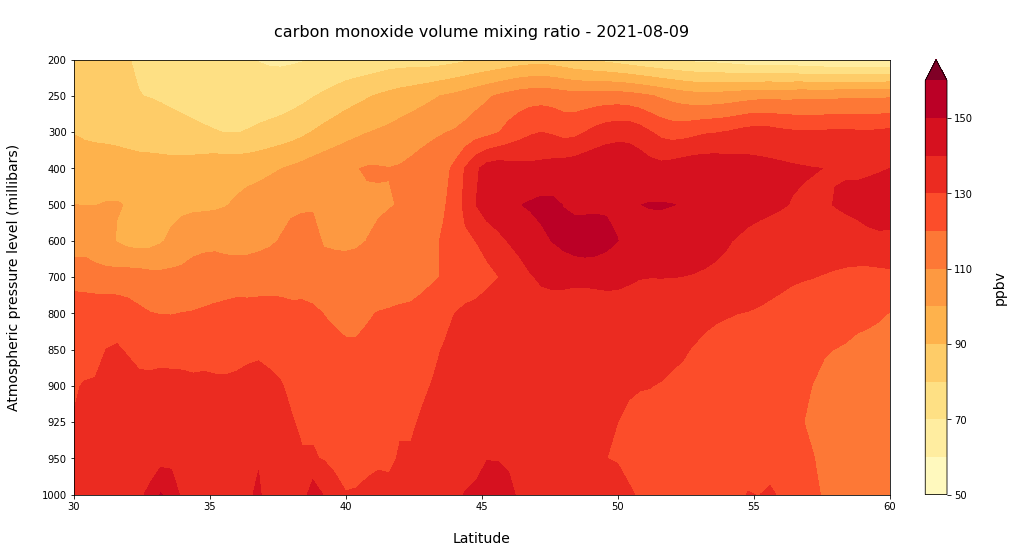

In [19]:
time_index = 8
# Define the figure and specify size
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot()

# Plot the figure with contourf
vdiv = 10
vmin = 50
vmax = 160+vdiv
clevs = np.arange(vmin,vmax,vdiv)
im = plt.contourf(co_zonal_area_mean.latitude, y, co_zonal_area_mean[time_index,:,:], clevs, cmap='YlOrRd', vmin=vmin, vmax=vmax, extend='max')

# Set x and y axis tickmarks, labels
ax.yaxis.set_ticks(y)
ax.yaxis.set_ticklabels(co_lat_area_mean.level.values)

# Set axes labels and title
ax.set_xlabel('\nLatitude', fontsize=14)
ax.set_ylabel('Atmospheric pressure level (millibars)\n', fontsize=14)
ax.set_title('\n'+ co_zonal_area_mean.long_name + ' - ' + str(co_zonal_area_mean.time[time_index].values)[0:10] + '\n', fontsize=16)

# Specify a colorbar
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('\n'+ co_zonal_area_mean.units, fontsize=14)

<hr>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.